In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")

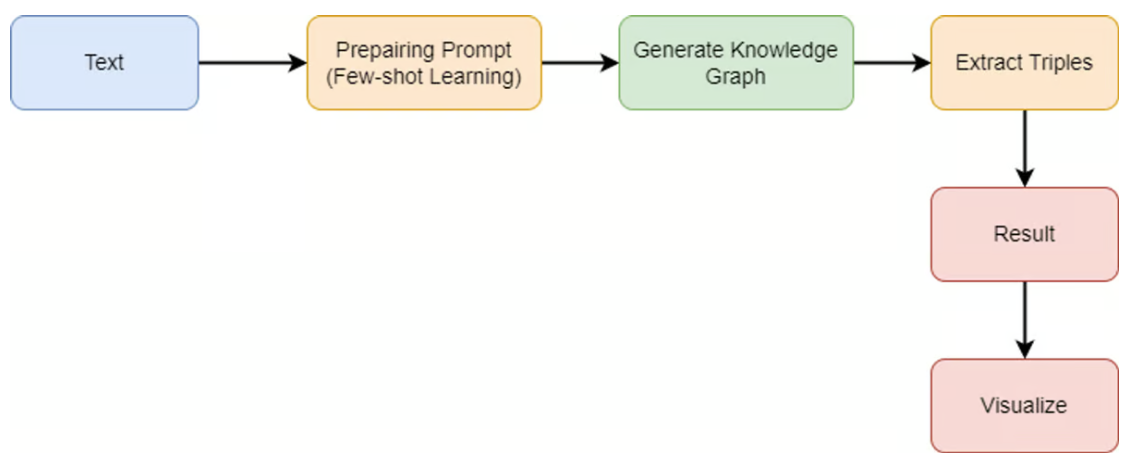

In [2]:
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAI
from langchain.chains import LLMChain
from langchain.graphs.networkx_graph import KG_TRIPLE_DELIMITER

# Prompt template for knowledge triple extraction
_DEFAULT_KNOWLEDGE_TRIPLE_EXTRACTION_TEMPLATE = (
    "You are a networked intelligence helping a human track knowledge triples"
    " about all relevant people, things, concepts, etc. and integrating"
    " them with your knowledge stored within your weights"
    " as well as that stored in a knowledge graph."
    " Extract all of the knowledge triples from the text."
    " A knowledge triple is a clause that contains a subject, a predicate,"
    " and an object. The subject is the entity being described,"
    " the predicate is the property of the subject that is being"
    " described, and the object is the value of the property.\n\n"
    "EXAMPLE\n"
    "It's a state in the US. It's also the number 1 producer of gold in the US.\n\n"
    f"Output: (Nevada, is a, state){KG_TRIPLE_DELIMITER}(Nevada, is in, US)"
    f"{KG_TRIPLE_DELIMITER}(Nevada, is the number 1 producer of, gold)\n"
    "END OF EXAMPLE\n\n"
    "EXAMPLE\n"
    "I'm going to the store.\n\n"
    "Output: NONE\n"
    "END OF EXAMPLE\n\n"
    "EXAMPLE\n"
    "Oh huh. I know Descartes likes to drive antique scooters and play the mandolin.\n"
    f"Output: (Descartes, likes to drive, antique scooters){KG_TRIPLE_DELIMITER}(Descartes, plays, mandolin)\n"
    "END OF EXAMPLE\n\n"
    "EXAMPLE\n"
    "{text}"
    "Output:"
)

KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT = PromptTemplate(
    input_variables=["text"],
    template=_DEFAULT_KNOWLEDGE_TRIPLE_EXTRACTION_TEMPLATE,
)

# Instantiate the OpenAI model
llm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.9)

# Create an LLMChain using the knowledge triple extraction prompt
chain = LLMChain(llm=llm, prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT)

# Run the chain with the specified text
text = "The city of Paris is the capital and most populous city of France. The Eiffel Tower is a famous landmark in Paris."
triples = chain.invoke(text)

print(triples)

{'text': ' (Paris, is the capital of, France)<|>(Paris, is the most populous city of, France)<|>(Eiffel Tower, is a, famous landmark)<|>(Eiffel Tower, is a landmark in, Paris)'}


In [3]:
def parse_triples(response, delimiter=KG_TRIPLE_DELIMITER):
    if not response:
        return []
    return response.split(delimiter)

triples_list = parse_triples(triples['text'])

# Print the extracted relation triplets
print(triples_list)

[' (Paris, is the capital of, France)', '(Paris, is the most populous city of, France)', '(Eiffel Tower, is a, famous landmark)', '(Eiffel Tower, is a landmark in, Paris)']


## Knowledge Graph Visualization

In [5]:
from pyvis.network import Network
import networkx as nx

# Create a NetworkX graph from the extracted relation triplets
def create_graph_from_triplets(triplets):
    G = nx.DiGraph()
    for triplet in triplets:
        subject, predicate, obj = triplet.strip().split(',')
        G.add_edge(subject.strip(), obj.strip(), label=predicate.strip())
    return G

# Convert the NetworkX graph to a PyVis network
def nx_to_pyvis(networkx_graph):
    pyvis_graph = Network(notebook=True, cdn_resources='remote')
    for node in networkx_graph.nodes():
        pyvis_graph.add_node(node)
    for edge in networkx_graph.edges(data=True):
        pyvis_graph.add_edge(edge[0], edge[1], label=edge[2]["label"])
    return pyvis_graph

triplets = [t.strip() for t in triples_list if t.strip()]
graph = create_graph_from_triplets(triplets)
pyvis_network = nx_to_pyvis(graph)

# Customize the appearance of the graph
pyvis_network.toggle_hide_edges_on_drag(True)
pyvis_network.toggle_physics(False)
pyvis_network.set_edge_smooth('discrete')

# Show the interactive knowledge graph visualization
test = pyvis_network.show("knowledge_graph.html")

knowledge_graph.html
